In [1]:
%load_ext autoreload
%autoreload 2
p = print

from os.path import join
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from keras.models import Sequential, Model
from keras.layers import Dense, LSTM, Input, Flatten, Activation
from keras.regularizers import l2
from keras.optimizers import Adam

from keras_self_attention import SeqSelfAttention

from crypr.build import series_to_supervised, make_features
from crypr.util import get_project_path

Using TensorFlow backend.


In [2]:
tx = 72
ty = 1
coin = 'BTC'

def make_data_path(Xory, split, coin):
    return join(get_project_path(), 'data', 'processed', '{}_{}_multiple_smooth_{}.npy'.format(Xory, split, coin))

X_train = np.load(make_data_path('X', 'train', coin))
y_train = np.load(make_data_path('y', 'train', coin))
X_test = np.load(make_data_path('X', 'test', coin))
y_test = np.load(make_data_path('y', 'test', coin))

p(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(5616, 72, 8) (216, 72, 8) (5616, 1) (216, 1)


In [3]:
def make_attentive_model(tx: int, num_channels: int, ty:int, 
                         num_lstm_hidden=128, attention_width=12) -> Model:
    inputs = Input(shape=(tx, num_channels))
    X = LSTM(
        units=num_lstm_hidden, 
        return_sequences=True, 
        bias_initializer='zeros',
    )(inputs)
    X = SeqSelfAttention(
        units=32,
        attention_width=attention_width,
        attention_type=SeqSelfAttention.ATTENTION_TYPE_MUL,
        return_attention=False,
        history_only=False,
        kernel_initializer='glorot_normal',
        bias_initializer='zeros',
        kernel_regularizer=l2(1e-6),
        bias_regularizer=None,
        kernel_constraint=None,
        bias_constraint=None,
        use_additive_bias=True,
        use_attention_bias=True,
        attention_activation=None,
        attention_regularizer_weight=0.0,
    )(X)
    X = Flatten()(X)
    X = Dense(
        units=ty, 
        bias_initializer='zeros',
    )(X)
    X = Activation('linear')(X)
    model = Model(inputs=inputs, outputs=X)
    return model

In [4]:
att = make_attentive_model(tx=tx, num_channels=8, ty=ty, num_lstm_hidden=64, attention_width=16)
opt = Adam(lr=1e-3)

att.compile(optimizer=opt, loss='mse', metrics=['mae'])
att.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 72, 8)             0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 72, 64)            18688     
_________________________________________________________________
seq_self_attention_1 (SeqSel (None, 72, 64)            4097      
_________________________________________________________________
flatten_1 (Flatten)          (None, 4608)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 4609      
_________________________________________________________________
activation_1 (Activation)    (None, 1)                 0         
Total params: 27,394
Trainable params: 27,394
Non-trainable params: 0


In [5]:
att.fit(
    X_train, 
    y_train, 
    epochs=5, 
    batch_size=128,
    shuffle=True,
    validation_data=(X_test, y_test),
)

Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Train on 5616 samples, validate on 216 samples
Epoch 1/5
5616/5616 [==============================] - 6s 1ms/step - loss: 0.5374 - mean_absolute_error: 0.4404 - val_loss: 0.5399 - val_mean_absolute_error: 0.5059
Epoch 2/5
5616/5616 [==============================] - 5s 888us/step - loss: 0.4691 - mean_absolute_error: 0.3835 - val_loss: 0.5438 - val_mean_absolute_error: 0.5094
Epoch 3/5
5616/5616 [==============================] - 5s 884us/step - loss: 0.4524 - mean_absolute_error: 0.3677 - val_loss: 0.5288 - val_mean_absolute_error: 0.5014
Epoch 4/5
5616/5616 [==============================] - 5s 885us/step - loss: 0.4596 - mean_absolute_error: 0.3824 - val_loss: 0.5293 - val_mean_absolute_error: 0.5039
Epoch 5/5
5616/5616 [==============================] - 5s 899us/step - loss: 0.4495 - mean_absolute_error: 0.3747 - val_loss: 0.5734 - val_mean_absolute_error: 0

In [6]:
y_pred = att.predict(X_test)

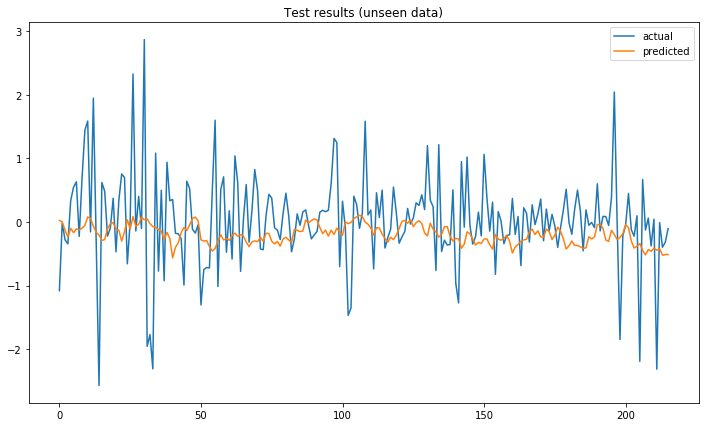

In [7]:
plt.subplots(figsize=(12, 7))
plt.plot(y_test, label='actual')
plt.plot(y_pred, label='predicted')
plt.title('Test results (unseen data)')
plt.legend()
plt.show()

In [8]:
from sklearn.metrics import mean_absolute_error
test_mae = mean_absolute_error(y_true=y_test, y_pred=y_pred)
p('Test MAE:', test_mae)

Test MAE: 0.5472498409671638
